In [2]:
#https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing

In [4]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'h:\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [5]:
from tqdm import tqdm
from tabulate import tabulate
from matplotlib import pyplot as plt

In [6]:
# selecting random number of images from multiple folders and copying it to the destination folder
# Combined Prediction (take new sample and make combine data)

import os
import shutil
import glob
import random
ctscan_covid_data = random.sample(glob.glob("Custom_Data/CT_Scan/Covid/CT_COVID/*.png"), 330)
ctscan_normal_data = random.sample(glob.glob("Custom_Data/CT_Scan/Normal/CT_nonCOVID/*"), 330)

ultrasound_covid_data = random.sample(glob.glob("Custom_Data/ultrasound/Covid/*"), 330)
ultrasound_normal_data = random.sample(glob.glob("Custom_Data/ultrasound/Normal/*.jpg"), 330)

xray_covid_data = random.sample(glob.glob("Custom_Data/X_ray/Covid/*.png"), 330)
xray_normal_data = random.sample(glob.glob("Custom_Data/X_ray/Normal/*.png"), 330)

# ctscan_covid_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Covid/*.png"), 330)
# ctscan_normal_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Normal/*"), 330)   

# ultrasound_covid_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Covid/*"), 330)
# ultrasound_normal_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Normal/*.jpg"), 330)

# xray_covid_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Normal/*.png"), 330)

covid_list=[ctscan_covid_data,ultrasound_covid_data,xray_covid_data]

normal_list = [ctscan_normal_data, ultrasound_normal_data,xray_normal_data]

if os.path.isdir('Data/Covid'):
    shutil.rmtree('Data/Covid')
    
if os.path.isdir('Data/Normal'):
    shutil.rmtree('Data/Normal')

for data in covid_list:
    dest = 'Data/Covid'
    if not os.path.isdir('Data/Covid'):
        os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

for data in normal_list:
    dest = 'Data/Normal' 
    if not os.path.isdir('Data/Normal'):
          os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

In [7]:
# pre-processing (image shape)
# X shape in 3 dimensions
# Y has 2 classes (Covid, Normal)
# make train and test data

class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X_train, self.X_test, self.labels_train, self.labels_test, self.y_train, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [8]:
# (660*3) * 0.7 = 1386
import os
import shutil
import glob
import random
data = Dataset("Data_91/", test_size=0.3, img_size=224)
print(data.X_train.shape, data.y_train.shape)
print(data.X_test.shape, data.y_test.shape)

(1386, 224, 224, 3) (1386, 2)
(594, 224, 224, 3) (594, 2)


In [9]:
print(data.X_train.shape[1:4])

(224, 224, 3)


In [9]:
mobinet_model = tf.keras.applications.MobileNetV2(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 7s 1us/step


In [10]:
resnet_model = tf.keras.applications.ResNet101V2(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

171317808/171317808 [==============================] - 22s 0us/step


In [8]:
vgg_model = tf.keras.applications.vgg19.VGG19(input_shape=data.X_train.shape[1:4], include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 9s 0us/step


In [10]:
# feature extractor model resnet 101 v2
# model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)

In [11]:
# covid_train_embedding = mobinet_model(data.X_train) # Mobinet
covid_train_embedding = resnet_model(data.X_train) # resnet
# covid_train_embedding = vgg_model(data.X_train) # vgg


#covid_test_embedding = mobinet_model(data.X_test)
print(covid_train_embedding.shape)

(1386, 7, 7, 2048)


In [12]:
##resnet
resnet_model.trainable = False
resnet_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
## Mobinet
mobinet_model.trainable = False
mobinet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# BATCH_SIZE = 32
# IMG_SIZE = (224, 224)
# dataset = tf.keras.utils.image_dataset_from_directory("Data",
#                                                       shuffle=True,
#                                                       batch_size=BATCH_SIZE,
#                                                       image_size=IMG_SIZE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input ##resnet

# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input ## Mobinet

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(covid_train_embedding)
print(feature_batch_average.shape)

(1386, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1386, 2)


In [17]:
data.X_train.shape[1:4]

(224, 224, 3)

In [18]:
# Model

inputs = tf.keras.Input(shape=(data.X_train.shape[1:4]))
x = data_augmentation(inputs)
x = preprocess_input(x)
# x = mobinet_model(x, training=False)
x = resnet_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [21]:
len(model.trainable_variables)

2

In [22]:
print(covid_train_embedding.shape)
print(feature_batch_average.shape)

(1386, 7, 7, 2048)
(1386, 2048)


In [23]:
# X_train_val = covid_train_embedding
# y_train_val = data.y_train
# data_train_labels = data.labels_train

In [24]:
# X_test_val = covid_test_embedding
# y_test_val = data.y_test
# data_test_labels = data.labels_test

In [25]:
# # Chaning shape for CNN2D
# # for 2048 - > [-1,2,2,512]
# # for 1280 - > [-1,2,2,320]

# covid_train_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_train_embedding2d.shape)

# covid_test_embedding2d = tf.reshape(feature_batch_average, [-1,2,2,320])
# print(covid_test_embedding2d.shape)

# X_train_val = covid_train_embedding2d
# X_test_val = covid_test_embedding2d

In [26]:
initial_epochs = 20
history = model.fit(data.X_train, data.y_train, epochs=initial_epochs, validation_data=(data.X_test, data.y_test))

Epoch 1/20
44/44 [==============================] - 101s 2s/step - loss: 0.8689 - accuracy: 0.4798 - val_loss: 0.8129 - val_accuracy: 0.4343
Epoch 2/20
44/44 [==============================] - 93s 2s/step - loss: 0.7935 - accuracy: 0.5209 - val_loss: 0.7613 - val_accuracy: 0.5067
Epoch 3/20
44/44 [==============================] - 94s 2s/step - loss: 0.7473 - accuracy: 0.5722 - val_loss: 0.7243 - val_accuracy: 0.5455
Epoch 4/20
44/44 [==============================] - 93s 2s/step - loss: 0.7107 - accuracy: 0.6140 - val_loss: 0.6917 - val_accuracy: 0.5993
Epoch 5/20
44/44 [==============================] - 93s 2s/step - loss: 0.7017 - accuracy: 0.6154 - val_loss: 0.6642 - val_accuracy: 0.6465
Epoch 6/20
44/44 [==============================] - 93s 2s/step - loss: 0.6673 - accuracy: 0.6465 - val_loss: 0.6422 - val_accuracy: 0.6549
Epoch 7/20
44/44 [==============================] - 92s 2s/step - loss: 0.6514 - accuracy: 0.6638 - val_loss: 0.6235 - val_accuracy: 0.6684
Epoch 8/20
44/44 [=

In [27]:
data.y_test.shape

(594, 2)

In [28]:
loss0, accuracy0 = model.evaluate(data.X_test, data.y_test)

19/19 [==============================] - 27s 1s/step - loss: 0.5028 - accuracy: 0.7778


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.50
initial accuracy: 0.78


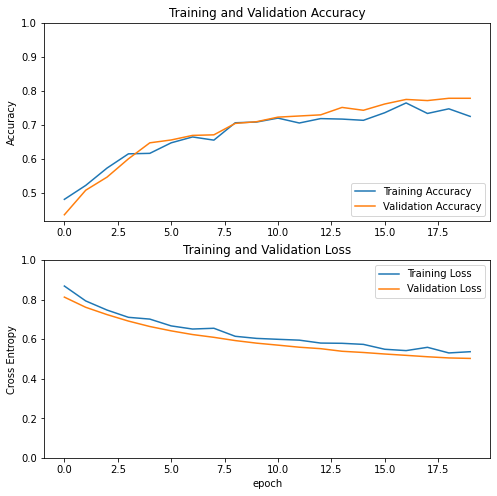

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine Tuning 

In [31]:
# mobinet_model.trainable = True #mobinet
resnet_model.trainable = True #resnet


In [32]:
# Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(mobinet_model.layers)) ##mobinet
print("Number of layers in the base model: ", len(resnet_model.layers)) ##resinet


# Fine-tune from this layer onwards
# fine_tune_at = 100 ## mobinet
fine_tune_at = 200 ## resnet


# Freeze all the layers before the `fine_tune_at` layer
# for layer in mobinet_model.layers[:fine_tune_at]:#mobinet
for layer in resnet_model.layers[:fine_tune_at]:

    layer.trainable = False

Number of layers in the base model:  377


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [35]:
len(model.trainable_variables)

163

In [37]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(data.X_train, data.y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(data.X_test, data.y_test))

Epoch 20/50
44/44 [==============================] - 190s 4s/step - loss: 0.0719 - accuracy: 0.9776 - val_loss: 0.2933 - val_accuracy: 0.9040
Epoch 21/50
44/44 [==============================] - 189s 4s/step - loss: 0.0871 - accuracy: 0.9697 - val_loss: 0.2582 - val_accuracy: 0.9108
Epoch 22/50
44/44 [==============================] - 189s 4s/step - loss: 0.0682 - accuracy: 0.9776 - val_loss: 0.2288 - val_accuracy: 0.9276
Epoch 23/50
44/44 [==============================] - 189s 4s/step - loss: 0.0660 - accuracy: 0.9791 - val_loss: 0.2485 - val_accuracy: 0.9276
Epoch 24/50
44/44 [==============================] - 189s 4s/step - loss: 0.0537 - accuracy: 0.9776 - val_loss: 0.2613 - val_accuracy: 0.9108
Epoch 25/50
44/44 [==============================] - 189s 4s/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.2551 - val_accuracy: 0.9125
Epoch 26/50
44/44 [==============================] - 189s 4s/step - loss: 0.0551 - accuracy: 0.9848 - val_loss: 0.4409 - val_accuracy: 0.8788
Epoch 

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

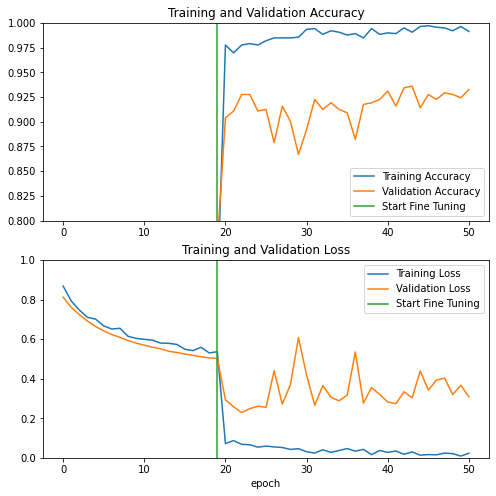

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
loss, accuracy = model.evaluate(data.X_test, data.y_test)
print('Test accuracy :', accuracy)

19/19 [==============================] - 27s 1s/step - loss: 0.3079 - accuracy: 0.9327
Test accuracy : 0.932659924030304


In [41]:
y_pred = model.predict(data.X_test)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(data.y_test, axis=1)

print(accuracy_score(y_test1, y_pred1))
print(confusion_matrix(y_test1,y_pred1))
print(classification_report(y_test1,y_pred1))

19/19 [==============================] - 29s 1s/step
0.9326599326599326
[[280  17]
 [ 23 274]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       297
           1       0.94      0.92      0.93       297

    accuracy                           0.93       594
   macro avg       0.93      0.93      0.93       594
weighted avg       0.93      0.93      0.93       594



### Graph Method for Resnet 101 v2

In [ ]:
# print(X_train_val.shape)
# print(y_train_val.shape)
# print(data_train_labels.shape)

In [ ]:
# print(X_test_val.shape)
# print(y_test_val.shape)
# print(data_test_labels.shape)

In [ ]:
# # test train split

# #Define Model
# model = Sequential()
# model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(1,1))
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(128,activation="relu"))
# model.add(Dense(y_train_val.shape[1], activation="sigmoid"))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# history = model.fit(X_train_val, y_train_val, epochs=32, batch_size=16, verbose=2, validation_data=(X_test_val, y_test_val))

# train_loss, train_acc = model.evaluate(X_train_val, y_train_val, verbose=0)
# test_loss, test_acc = model.evaluate(X_test_val, y_test_val, verbose=0)

In [ ]:
# model.summary()

In [ ]:
# print("Train Loss: " + str(train_loss))
# print("Train Accuracy: " + str(train_acc))

# print("Test Loss: " + str(test_loss))
# print("Test Accuracy: " + str(test_acc))

In [ ]:
# y_pred = model.predict(X_test_val)
# y_pred1 = np.argmax(y_pred, axis=1)
# y_test1 = np.argmax(y_test_val, axis=1)

# print(accuracy_score(y_test1, y_pred1))
# print(confusion_matrix(y_test1,y_pred1))
# print(classification_report(y_test1,y_pred1))

In [ ]:
# # ploting graph by using values of last epoch for graphs
# from matplotlib import pyplot as plt
# plt.style.use('ggplot')

# def plot_history(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     x = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(x, acc, 'b', label='Training acc')
#     plt.plot(x, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.ylabel('Accuracy value (%)')
#     plt.xlabel('No. epoch')
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     plt.plot(x, loss, 'b', label='Training loss')
#     plt.plot(x, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.ylabel('Loss value')
#     plt.xlabel('No. epoch')
#     plt.legend()

In [ ]:
# plot_history(history)

In [ ]:
# #All in one Graph (loss and accuracy)
# plt.style.use('default')
# plt.figure(figsize=(7, 3))
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.plot(history.history["loss"]) 
# plt.plot(history.history["val_loss"]) 
# plt.title("Model Evaluation")
# plt.ylabel("Value (%)")
# plt.xlabel("No. of Epochs")
# plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
# plt.show()